In [1]:
# checkpoints:

# dataclean fonts_df (with or without italic/bold)
# dataclean fonts_df: filter m_labels [recorded]

# dataclean fonts_df: pivot to (146, 26*20*20), embedding input [recorded]

# [notebook]: embedding input to 2D
# must use notebook for manual decisions (or configs) and (manual plotting)
# manual decisions: [decide embedding method (plot), number of k-means (plot)]
# since first plot (with hoverable scatterplot) can only be seperate, 2 notebooks are needed
# manual labelling


# creation & saving of embedding_input to temp (146, 26*20*20) [saved to temp]
# 2D Embedding of embedding_input (146, 2), with color [saved to temp for interactive]
# see # of clusters, [requires interactive notebook] then kmeans
# 
# (optional) EDA with unsupervised: eigen, scatterplot on embedding_input [notebook]
# models

In [2]:
# Data-Clean, then branches as either EDA or Feature Engineering

In [3]:
%matplotlib notebook

In [4]:
import os

import pandas as pd
import numpy as np
import tqdm

import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import numpy as np; 

from sklearn.manifold import SpectralEmbedding
from sklearn.manifold import spectral_embedding
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
#np.random.seed(42)

In [5]:
class Temp_Clustering:
    def __init__(self, args):
        self.args = args
        method = self.args["cluster_method"]
        self.method = method
        if method in ["k_means"]:
            k_means_num_clusters = args["k_means_num_clusters"]
            self.clusterer = KMeans(n_clusters = k_means_num_clusters)
        if method in ["dbscan"]:
            dbscan_eps = args["dbscan_eps"]
            self.clusterer = DBSCAN(eps = dbscan_eps)
        if method in ["hierarchical"]:
            self.clusterer = hierarchy
    def fit(self, data):
        clustering = self.clusterer.fit(data)
        return clustering
    def __call__(self, data):
        if self.method in ["hierarchical"]:
            clustering = self.clusterer.linkage(data, "ward")
            return clustering
        clustering = self.fit(data)
        return clustering.labels_

In [6]:
class Temp_Embedding:
    def __init__(self, args):
        self.args = args
        num_embeddings = self.args["num_embeddings"]
        self.num_embeddings = num_embeddings
        method = args["embedding_method"]
        self.method = method
        if method in ["pca"]:
            self.embedder = PCA(n_components = num_embeddings)
        if method in ["spectral_embedding"]:
            self.embedder = SpectralEmbedding(n_components = num_embeddings, affinity = "nearest_neighbors")
            #self.embedder = SpectralEmbedding(n_components = num_embeddings, affinity = "nearest_neighbor")
    def fit_transform(self, data):
        embedding = self.embedder.fit_transform(data)
        return embedding
    def __call__(self, data):
        embedding = self.fit_transform(data)
        
        return embedding

In [7]:
class Temp_Embedding_Cluster_Scatterplot:
    def __init__(self, data, embedding, colors=None):
        self.data = data # the original 146 by 26*400 matrix
        self.embedding = embedding
        self.x = embedding[:, 0]
        self.y = embedding[:, 1]
        arr = [] #np.empty((len(x),20*3,20))
        for i in range(len(self.x)):
            arr.append(self.data[i,0:1600].reshape(20*4, 20))
        self.arr = np.array(arr)
        self.colors = colors
    
    def add_colors(self, groups):
        self.colors = list(map(lambda i: (list("rgby"))[i], groups))  

    def hover(self, event):
        # if the mouse is over the scatter points
        if self.line.contains(event)[0]:
            # find out the index within the array from the event
            ind, = self.line.contains(event)[1]["ind"]
            # get the figure size
            w,h = self.fig.get_size_inches()*self.fig.dpi
            ws = (event.x > w/2.)*-1 + (event.x <= w/2.) 
            hs = (event.y > h/2.)*-1 + (event.y <= h/2.)
            # if event occurs in the top or right quadrant of the figure,
            # change the annotation box position relative to mouse.
            self.ab.xybox = (self.xybox[0]*ws, self.xybox[1]*hs)
            # make annotation box visible
            self.ab.set_visible(True)
            # place it at the position of the hovered scatter point
            self.ab.xy =(self.x[ind], self.y[ind])
            self.ab.xy =(self.x[ind], self.y[ind])
            # set the image corresponding to that point
            self.im.set_data(self.arr[ind,:,:])
        else:
            #if the mouse is not over a scatter point
            self.ab.set_visible(False)
        self.fig.canvas.draw_idle()
    

    def draw(self):
        # create figure and plot scatter
        self.fig = plt.figure(figsize=(8,8))
        self.ax = self.fig.add_subplot(111)
        self.line, = self.ax.plot(self.x,self.y, alpha=0.2,
                        ls="",
                        marker="o",
                        c="gray"
                       )
        self.ax.scatter(self.x, self.y, c=self.colors)

        # create the annotations box
        self.im = OffsetImage(self.arr[0,:,:], zoom=5)
        self.xybox=(50., 50.)
        self.ab = AnnotationBbox(self.im, (0,0), xybox=self.xybox, xycoords='data',
                boxcoords="offset points",  pad=0.3,  arrowprops=dict(arrowstyle="->"))
        # add it to the axes and make it invisible
        self.ax.add_artist(self.ab)
        self.ab.set_visible(False)

        # add callback for mouse moves
        self.fig.canvas.mpl_connect('motion_notify_event', self.hover)           
        plt.show()        

In [8]:
# font: remove fonts that lack alpha_num (for both rounds)
# fontVariant: remove scanned (for both rounds)
# strength: keep only those <= 0.5
# italic: keep only those <= 0.5
# m_label: keep just uppercase (just for clustering)
# orientation: irrelevant, all values = 0
# m_top
# m_left
# originalH
# originalW
# h: irrelevant, all values = 20
# w: irrelevant, all values = 20

In [9]:
# CONSTANTS
pixel_column_names = []
for i in range(0, 20):
    for j in range(0, 20):
        pixel_column_name = "r{0}c{1}".format(str(i),str(j))
        pixel_column_names.append(pixel_column_name)


#m_labels_all = list(range(33, 221+1)) + [229, 230, 248]

m_labels_num = list(range(49, 58+1))
m_labels_uppercase = list(range(65, 90+1))
m_labels_lowercase = list(range(97, 122+1))

m_labels_alpha = m_labels_uppercase + m_labels_lowercase
m_labels_alpha_num = m_labels_uppercase + m_labels_lowercase + m_labels_num

# CONFIG CONSTANTS

path_folder = "../../data/raw/"
file_name = "fonts.csv"
path_file = os.path.join(path_folder, file_name)

In [11]:
def get_overlapping_m_labels(sufficient_fonts, fonts_df):
    series = (fonts_df[fonts_df["font"].isin(sufficient_fonts)]
    .drop_duplicates(subset=["font","m_label"])
    )["m_label"].value_counts()
    series_set = set(list(series.index[np.where(series==series.max())[0]]))
    return series_set

In [23]:
def get_sufficient_fonts(m_labels_bare_minimum, fonts_df):
    
    temp_fonts_df = fonts_df

    sufficient_fonts = set(temp_fonts_df["font"])

    #m_labels_bare_minimum = m_labels_alpha_num
    m_labels_set_by_fonts = temp_fonts_df.groupby(["font"])["m_label"].apply(set)
    m_labels_set_adequate_by_fonts = m_labels_set_by_fonts.apply(lambda x: (set(m_labels_bare_minimum)).issubset(x))
    temp_sufficient_fonts = list(
        np.array(m_labels_set_adequate_by_fonts.index)[np.where(m_labels_set_adequate_by_fonts.values)[0]]
    )

    sufficient_fonts &= set(temp_sufficient_fonts)

    orientation_by_fonts = temp_fonts_df.groupby(temp_fonts_df["orientation"]==0.0)["font"].apply(set)
    temp_sufficient_fonts = orientation_by_fonts[True]
    sufficient_fonts &= set(temp_sufficient_fonts)

    scanned_by_fonts = temp_fonts_df.groupby(temp_fonts_df["fontVariant"] != "scanned")["font"].apply(set)
    temp_sufficient_fonts = scanned_by_fonts[True]
    sufficient_fonts &= set(temp_sufficient_fonts)

    return list(sufficient_fonts)

In [22]:
fonts_df = pd.read_csv(path_file)

In [24]:
sufficient_fonts = get_sufficient_fonts(m_labels_alpha_num, fonts_df)

# m_labels_overlapping = get_overlapping_m_labels(sufficient_fonts, fonts_df)
# m_labels_overlapping = list(range(33, 221+1)) + [229, 230, 248]

m_labels_selection = m_labels_uppercase + m_labels_num

In [25]:
# fixed 
fonts_df = fonts_df[fonts_df["font"].isin(sufficient_fonts)]
fonts_df = fonts_df[~fonts_df["fontVariant"].isin(["scanned"])]

In [26]:
fonts_df_ = fonts_df.copy()

In [27]:
# variable
fonts_df = fonts_df[fonts_df["m_label"].isin(m_labels_selection)]
fonts_df = fonts_df[fonts_df["strength"]<= 0.5]
fonts_df = fonts_df[fonts_df["italic"]<= 0.5]

In [28]:
# fixed
fonts_df = fonts_df.sort_values(["font","fontVariant","m_label"])
fonts_df = fonts_df.drop_duplicates(subset=["font","m_label","strength","italic"]) 
fonts_df = fonts_df.sort_values([
    "font",
    "fontVariant","italic",  "strength",
    "m_label"
]) # optional

In [29]:
h = 20
w = 20
fonts = fonts_df["font"].drop_duplicates().values
fonts_amount = len(fonts)
m_labels_selection_amount = len(m_labels_selection)

embedding_input = fonts_df[pixel_column_names].values.reshape(fonts_amount, 
                                                              m_labels_selection_amount*1*h*w)
data = embedding_input

# embedding method
embedding_methods = ["pca","spectral_embedding"]
embedding_method = embedding_methods[0]
num_embeddings = 2

# cluster method
cluster_methods = ["k_means", "dbscan", "hierarchical"]
cluster_method = cluster_methods[2]
k_means_num_clusters = 4
dbscan_eps = 1700

temp_args = {}
temp_args["embedding_method"] = embedding_method
temp_args["num_embeddings"] = num_embeddings
temp_args["cluster_method"] = cluster_method
temp_args["k_means_num_clusters"] = k_means_num_clusters
temp_args["dbscan_eps"] = dbscan_eps

# pca, kmeans, 4 = trash
# pca, dbscan, 0.5 = trash
# pca, dbscan, 1600 = okayish
# hierarchical at 4 is pretty good.

embedder = Temp_Embedding(temp_args)
embedding = embedder(data)

clusterer = Temp_Clustering(temp_args)
clustering = clusterer(embedding)

scatter = Temp_Embedding_Cluster_Scatterplot(data, embedding)
scatter.add_colors(clustering)
scatter.draw()

In [31]:
clusterer = Temp_Clustering(temp_args)
clustering = clusterer(data)

<IPython.core.display.Javascript object>


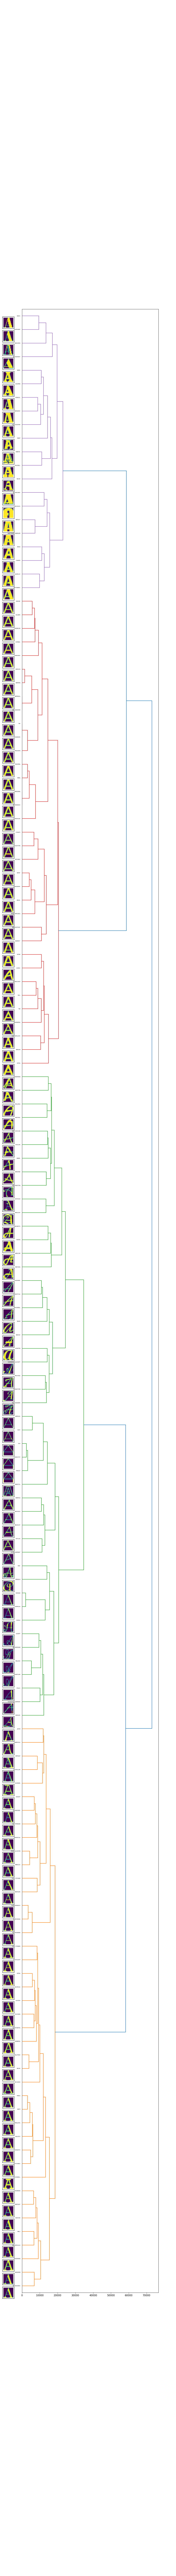

In [40]:
fig = plt.figure(figsize=(10,len(fonts)))
ax = fig.add_subplot(111)

output = hierarchy.dendrogram(clustering, 
                              orientation="right",
                              labels=fonts,
                              ax=ax
                             )
#ims = []
dendrogram_fonts = output['ivl']
dendrogram_fonts_amount = len(dendrogram_fonts)
for temp_font_i in range((dendrogram_fonts_amount)):
    temp_font = dendrogram_fonts[temp_font_i]
    temp_im_y_coord = temp_font_i/dendrogram_fonts_amount
    h = 20
    w = 20
    temp_font_idx = list(fonts).index(temp_font)
    temp_font_pixels_row = data[temp_font_idx,:]
    char_amount = 1
    starter_char_index = 10*400
    starter_index = starter_char_index
    temp_font_pixels_row_subset = temp_font_pixels_row[starter_index:starter_index+h*w*char_amount]
    temp_arr = (
        temp_font_pixels_row_subset
        .reshape(char_amount, h*w)
        .T
        .reshape(h,w,char_amount)
        .transpose(0,2,1)
        .reshape(h, w*char_amount)
    )
    temp_im = OffsetImage(temp_arr, zoom=2)
    temp_im.image.axes = ax
    adjustor = 0#(1/dendrogram_fonts_amount)*0.5
    temp_xy = (-0.1,  temp_im_y_coord + adjustor)
    temp_ab = AnnotationBbox(temp_im, temp_xy, xycoords='axes fraction')
    ax.add_artist(temp_ab)

plt.show()

In [130]:
# https://www.python-graph-gallery.com/401-customised-dendrogram

In [33]:
clustering

array([[9.10000000e+01, 1.32000000e+02, 0.00000000e+00, 2.00000000e+00],
       [7.90000000e+01, 9.40000000e+01, 0.00000000e+00, 2.00000000e+00],
       [1.11000000e+02, 1.39000000e+02, 0.00000000e+00, 2.00000000e+00],
       [4.10000000e+01, 5.50000000e+01, 1.49757638e+03, 2.00000000e+00],
       [3.10000000e+01, 1.14000000e+02, 2.01860546e+03, 2.00000000e+00],
       [8.80000000e+01, 1.38000000e+02, 2.49633351e+03, 2.00000000e+00],
       [9.30000000e+01, 1.31000000e+02, 3.09714336e+03, 2.00000000e+00],
       [2.00000000e+00, 1.35000000e+02, 3.11750237e+03, 2.00000000e+00],
       [1.03000000e+02, 1.46000000e+02, 3.13938571e+03, 3.00000000e+00],
       [1.07000000e+02, 1.51000000e+02, 3.15787655e+03, 3.00000000e+00],
       [1.00000000e+02, 1.28000000e+02, 3.49040642e+03, 2.00000000e+00],
       [1.10000000e+01, 9.90000000e+01, 3.86825762e+03, 2.00000000e+00],
       [1.16000000e+02, 1.20000000e+02, 4.05630669e+03, 2.00000000e+00],
       [1.48000000e+02, 1.52000000e+02, 4.09724084e